Using device: cpu
Loading Fashion-MNIST dataset...
Training samples: 60000
Test samples: 10000

Model Architecture:
CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, 

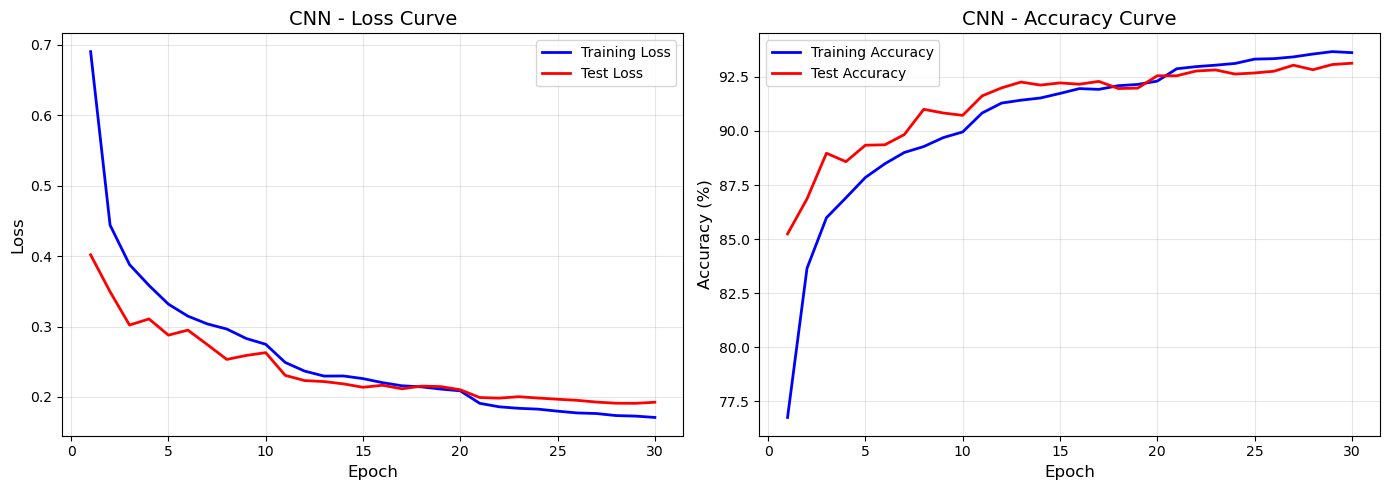

Results saved to cnn_results.png
Model saved to cnn_fashion_mnist.pth


In [2]:
"""
Classic CNN for Fashion-MNIST
经典的卷积神经网络设计，类似LeNet-5的结构但更现代化
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time

# 设置随机种子
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class CNN(nn.Module):
    """
    经典CNN设计 (类似增强版LeNet-5):
    - Conv1: 1->32 filters, 5x5, padding=2 -> 28x28x32
    - MaxPool: 2x2 -> 14x14x32
    - Conv2: 32->64 filters, 5x5, padding=2 -> 14x14x64
    - MaxPool: 2x2 -> 7x7x64
    - Conv3: 64->128 filters, 3x3, padding=1 -> 7x7x128
    - FC1: 7*7*128 -> 1024
    - FC2: 1024 -> 512
    - FC3: 512 -> 10
    """
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        # 卷积层
        self.conv_layers = nn.Sequential(
            # 第一个卷积块
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 第二个卷积块
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 第三个卷积块
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        # 全连接层
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


def load_data(batch_size=128):
    """加载Fashion-MNIST数据集"""
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=transform_train
    )
    test_dataset = datasets.FashionMNIST(
        root='./data', train=False, download=True, transform=transform_test
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader


def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    return running_loss / len(train_loader), 100. * correct / total


def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    return test_loss / len(test_loader), 100. * correct / total


def plot_results(train_losses, train_accs, test_losses, test_accs, model_name='CNN'):
    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(epochs, test_losses, 'r-', label='Test Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title(f'{model_name} - Loss Curve', fontsize=14)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs, train_accs, 'b-', label='Training Accuracy', linewidth=2)
    axes[1].plot(epochs, test_accs, 'r-', label='Test Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title(f'{model_name} - Accuracy Curve', fontsize=14)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{model_name.lower()}_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Results saved to {model_name.lower()}_results.png")


def main():
    batch_size = 128
    learning_rate = 0.001
    num_epochs = 30

    print("Loading Fashion-MNIST dataset...")
    train_loader, test_loader = load_data(batch_size)
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}")

    model = CNN(num_classes=10).to(device)

    print(f"\nModel Architecture:\n{model}")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    print("\nStarting training...")
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test(model, test_loader, criterion, device)

        scheduler.step()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Epoch [{epoch:2d}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best Test Accuracy: {max(test_accs):.2f}%")

    plot_results(train_losses, train_accs, test_losses, test_accs, 'CNN')

    torch.save(model.state_dict(), 'cnn_fashion_mnist.pth')
    print("Model saved to cnn_fashion_mnist.pth")


if __name__ == '__main__':
    main()